# ISC505 term project
## Fast Gravitational waveform generation using ANNs 
### By Jordan Moncrieff

# Installs

Relevant moduls, may take a while to install.

Note: may not work on your system, I had to use Google Colab to get the modules to work

In [1]:
# ! pip install pycbc ## Will not work on windows - use Google colab instead
# ! pip install --upgrade tensorflow
# ! pip install keras
# ! pip install pysindy ## Will not work on windows - use Google colab instead

# Data generation

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
%timeit
##########################################################
#### This will not work on windows, use colab to run  ####
##########################################################

import pycbc
%matplotlib inline
import numpy as np
from pycbc import waveform
from pycbc.waveform import get_td_waveform
import pylab

# Generate amplitude data within 10ms of ringdown
amplitudes = []
i = 0
for q in np.linspace(1,8,num=701):
    # Mass ratios from 1:1 to 1:8 in steps of 0.01
    # Start frequency is 30Hz when q=1, and total mass is 20 solar masses
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt", mass1=10, mass2=10*q,
                             delta_t=1.0/4096, f_lower=60/(1+q))
    hp, hc = hp.trim_zeros(), hc.trim_zeros()
    amp = waveform.utils.amplitude_from_polarizations(hp, hc)
    t = hp.sample_times
    max_amp_index = np.argmax(amp)
    time_max_amp = t[max_amp_index]
    t = t-time_max_amp              # Shift plot so max amplitude is at t=0
    time_mask = np.logical_and(t>=-0.01,t<=0.01)
    times = t[time_mask]
    amplitudes+= [amp[time_mask]]
np.savetxt("amplitude_data_full.txt",np.array(amplitudes), delimiter = ",") # Save to file

# Data processing

Read from file, generating from code above takes a while

In [4]:
# amplitudes = np.array(amplitudes)                                             # Do this if ran previous code already
amplitudes = np.genfromtxt('amplitude_data.txt',delimiter=',',dtype=np.float64) # Do this instead of regenerating data
t = np.linspace(-0.01, 0.01, num=np.size(amplitudes[0]))                        # Reconstruct time series sampled
q = np.linspace(1, 8, num=701)                                                  # Recreate mass ratios used in simulation

Scale/normalize data, more interperatable and faster learning rate

In [6]:
Q, T = np.meshgrid(q, t)        # Create meshgrid for plotting and latter analysis
Q, T = Q.T / 8, T.T / 1e-2      # Transpose to make more interperatable, scale to make variables of order 1
A = amplitudes / 1e-19          # Scale amplitude to make data O(1)

Split data (randomly) into training, validation, and testing data. Vectorize (flatten) arrays for later use

In [7]:
shap = Q.flatten().shape

num_samples = 50000                                             # Number of points sampled
train_split, validate_split, test_split = 0.7, 0.15, 0.15       # Split of data for training, validating, and testing
num_training = int(num_samples*train_split)
num_validate = int(num_samples*validate_split)
num_test = int(num_samples*test_split)

# Randomly select random (and unique) points for each of the training, validation, and testing data sets
random_index = np.random.randint(0, shap[0], size=num_samples)

random_index_training = random_index[0:num_training]

random_index_validating = random_index[num_training:num_training+num_validate]

random_index_testing = random_index[num_training+num_validate:num_training+num_validate+num_test]

# Training data
Q_train = Q.flatten()[random_index_training]
T_train = T.flatten()[random_index_training]
A_train = A.flatten()[random_index_training]

# Randomly select points for validation
Q_val = Q.flatten()[random_index_validating]
T_val = T.flatten()[random_index_validating]
A_val = A.flatten()[random_index_validating]

# Randomly select points for testing
Q_test = Q.flatten()[random_index_testing]
T_test = T.flatten()[random_index_testing]
A_test = A.flatten()[random_index_testing]

# Visualising data

What does a gravitational wave form look like?

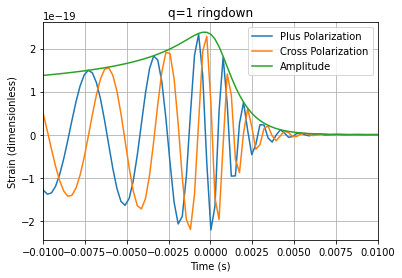

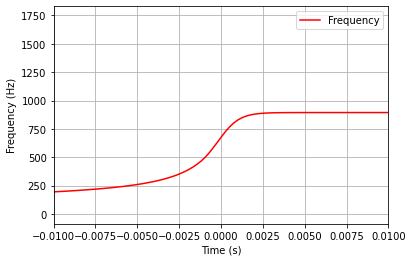

In [44]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30)

amp = waveform.utils.amplitude_from_polarizations(hp, hc)
freq = waveform.utils.frequency_from_polarizations(hp, hc)

# Zoom in near the merger time#
plt.plot(hp.sample_times, hp, label='Plus Polarization')
plt.plot(hp.sample_times, hc, label='Cross Polarization')
plt.plot(hp.sample_times, amp, label='Amplitude')

plt.title("q=1 ringdown")
plt.xlabel('Time (s)')
plt.ylabel("Strain (dimensionless)")
plt.xlim(-.01, .01)
plt.legend()
plt.grid()
plt.show()

plt.plot(hp.sample_times[:-1], freq, label='Frequency', c="r")
plt.ylabel("Frequency (Hz)")
plt.xlabel('Time (s)')
plt.xlim(-.01, .01)
plt.legend()
plt.grid()
plt.show()

Plot strain as a function of time, with different parameter values of q

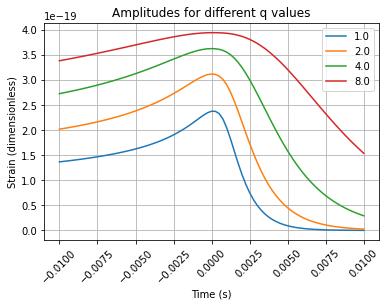

In [45]:
plt.plot(t, amplitudes[0], label=q[0])
plt.plot(t, amplitudes[100], label=q[100])
plt.plot(t, amplitudes[300], label = q[300])
plt.plot(t, amplitudes[700], label=q[700])
plt.xticks(rotation=45)
plt.legend()
plt.title("Amplitudes for different q values")
plt.xlabel('Time (s)')
plt.ylabel("Strain (dimensionless)")
plt.grid()

Show 3D plot representing entire parameter space (A,q,t)

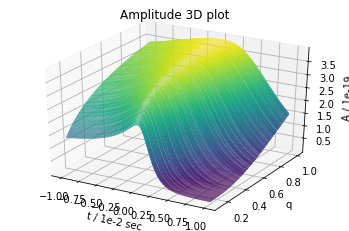

In [46]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(T, Q, A, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

ax.set_title('Amplitude 3D plot')
ax.set_xlabel('t / 1e-2 sec')
ax.set_ylabel('q')
ax.set_zlabel('A / 1e-19')

fig.show()


Goal of this project is to be able to quickly and accurately calculate Amplitude of gravitational waveform at a given time, near ringdown, given the input parameter $q:=\frac{m_1}{m_2}$ (the mass ratio of non-spinning black holes)

We will achieve this by building a regression model of the system via an artificial neural network (ANN), with 
- Inputs: Mass ratio $(q)$, Time $(t)$
- Output: Amplitude $A(t;q)$

Methods used here are easily generalised to the higher dimensional parameter spaces of more complex (spinning) black holes, but are not treated here due to time constraints and (lack of) computational resources

# Neural network regression

We will be utilising the Python machine learning module Tensorflow, specifically the Keras API

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

We now build the initial model
- Multilayer Perceptron architecture, with two hidden layers having ten nodes each
- Use Nesterov accelerated gradient optimization for learning algorithm, with learning rate = momentum = 0.01
- ReLU activation for hidden layers, linear activation for output layer, MSE loss function
- Randomly split data into 70% training, 15% validation, and 15% for testing

In [8]:
# Training data
X_train = np.array([Q_train, T_train])  # Inputs
Y_train = np.array([A_train])           # Responce

# Validation data
X_val = np.array([Q_val, T_val])
Y_val = np.array([A_val])

# Testing data
X_test = np.array([Q_test, T_test])
Y_test = np.array([A_test])

# Create model
model = Sequential()
model.add(Dense(10, activation="relu", input_dim=2))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="linear"))

# Compile model
model.compile(loss='mean_squared_error', optimizer=SGD(momentum=0.01, nesterov=True))

# Fit the model
history = model.fit(X_train.T, Y_train.T, validation_data=(X_val.T, Y_val.T), epochs=25, verbose=2)

# Calculate predictions on test and validation set
PredTestSet = model.predict(X_test.T)
PredValSet = model.predict(X_val.T)

Epoch 1/25
1094/1094 - 2s - loss: 0.2170 - val_loss: 0.0243 - 2s/epoch - 2ms/step
Epoch 2/25
1094/1094 - 1s - loss: 0.0223 - val_loss: 0.0200 - 1s/epoch - 1ms/step
Epoch 3/25
1094/1094 - 1s - loss: 0.0186 - val_loss: 0.0167 - 1s/epoch - 1ms/step
Epoch 4/25
1094/1094 - 1s - loss: 0.0156 - val_loss: 0.0141 - 1s/epoch - 1ms/step
Epoch 5/25
1094/1094 - 1s - loss: 0.0129 - val_loss: 0.0118 - 1s/epoch - 1ms/step
Epoch 6/25
1094/1094 - 1s - loss: 0.0107 - val_loss: 0.0097 - 1s/epoch - 1ms/step
Epoch 7/25
1094/1094 - 1s - loss: 0.0090 - val_loss: 0.0085 - 1s/epoch - 1ms/step
Epoch 8/25
1094/1094 - 1s - loss: 0.0078 - val_loss: 0.0073 - 1s/epoch - 1ms/step
Epoch 9/25
1094/1094 - 1s - loss: 0.0068 - val_loss: 0.0067 - 1s/epoch - 1ms/step
Epoch 10/25
1094/1094 - 2s - loss: 0.0062 - val_loss: 0.0061 - 2s/epoch - 1ms/step
Epoch 11/25
1094/1094 - 2s - loss: 0.0057 - val_loss: 0.0058 - 2s/epoch - 2ms/step
Epoch 12/25
1094/1094 - 2s - loss: 0.0053 - val_loss: 0.0052 - 2s/epoch - 1ms/step
Epoch 13/25
1

Plot loss at each epoch

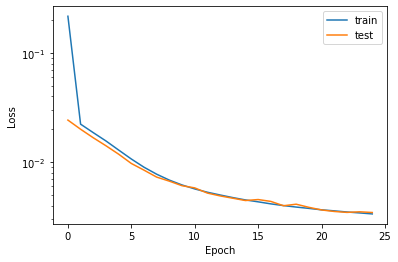

In [9]:
plt.semilogy(history.history['loss'], label='train')
plt.semilogy(history.history['val_loss'], label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Compare predicted vs actual values on test set, compute R-square error

Training Set R-Square= 0.9972909645724094


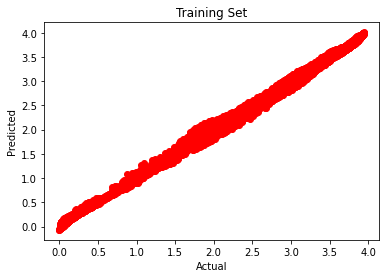

In [10]:
from sklearn.metrics import r2_score

# Plot actual vs prediction for training set
plt.plot(A_test,PredTestSet,'ro')
plt.title('Training Set')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Compute R-Square value for training set
TestR2Value = r2_score(A_test,PredTestSet)
print("Training Set R-Square=", TestR2Value)

$R^2=0.998$, not bad

See how NN model prediction fits test data

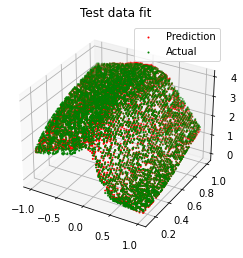

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter3D(T_test, Q_test, PredTestSet.T[0], c="red", s=1, label="Prediction")
ax.scatter3D(T_test, Q_test, A_test, c="green", s=1, label="Actual")
ax.set_title("Test data fit")
ax.legend()

Qualitatively, very good fit. Not perfect, so we'll see if we can do better by hyperparameter tuning

### Hyperparameter tuning

We tune the following hyperparameters
1. Number of layers
2. Number of nodes per layer
3. Learning rate
4. Momentum

We perfrom tuning on 1 and 2 together, then use the resulting optimal architecture to tune 3 and 4 together

There are built in methods in Keras and Sklearn to do this automatically, but our approach is to just loop through possible parameter values and choose the parameters based on which models fit the validation data best, as shown in class

#### Grid search on number of layers and nodes

In [12]:
# Possible node and layer sizes
layers = [1, 2, 3, 4, 5, 6]
nodes = [2, 4, 8, 10, 12, 16]

# Use a smaller sample of training and validation data in order for code to run faster
X_train, Y_train = X_train[:,:7000], Y_train[:,:7000]
X_val, Y_val = X_val[:,:1500], Y_val[:,:1500]

def build_model(num_nodes, num_layers):
    model = Sequential()
    model.add(Dense(num_nodes, activation="relu", input_dim=2))
    # Add (num_layers - 1) more layers to NN
    for _ in range(len(range(num_layers))-1):
        model.add(Dense(num_nodes, activation="relu"))
    # Add activation layer
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer=SGD(momentum=0.01, nesterov=True))
    return model

lst = []    # Store CV error
i=0         # Keep track of index
# Loop over layer and node sixe
for layer in layers:
    for node in nodes:
        # Repeat 10 times and average, to reduce randomness
        CV_sum = 0
        for _ in range(10):
            model = build_model(node, layer)
            history = model.fit(X_train.T, Y_train.T, validation_data=(X_val.T, Y_val.T),
                    epochs=10, verbose=0)
            CV = history.history['val_loss'][-1]    # CV error at last epoch
            CV_sum += CV
        CV = CV_sum / 10                             # Take CV to be average
        print(f"{i}: {layer} layers, {node} nodes, has cross validation error {CV}")
        lst.append(CV)                          # Save for later analysis
        i += 1


0: 1 layers, 2 nodes, has cross validation error 0.24315100125968456
1: 1 layers, 4 nodes, has cross validation error 0.13724742867052556
2: 1 layers, 8 nodes, has cross validation error 0.09108910784125328
3: 1 layers, 10 nodes, has cross validation error 0.05173464417457581
4: 1 layers, 12 nodes, has cross validation error 0.05142768174409866
5: 1 layers, 16 nodes, has cross validation error 0.05045978650450707
6: 2 layers, 2 nodes, has cross validation error 0.7033186510205269
7: 2 layers, 4 nodes, has cross validation error 0.051194101199507715
8: 2 layers, 8 nodes, has cross validation error 0.02693535927683115
9: 2 layers, 10 nodes, has cross validation error 0.029310416802763938
10: 2 layers, 12 nodes, has cross validation error 0.02303679585456848
11: 2 layers, 16 nodes, has cross validation error 0.024119214806705713
12: 3 layers, 2 nodes, has cross validation error 0.5020930603146553
13: 3 layers, 4 nodes, has cross validation error 0.15652737878262996
14: 3 layers, 8 nodes, 

In [13]:
sorted(enumerate(lst),key=lambda x: x[-1])  # Get sorted list of best model parameters, 5 layers 12 nodes usually good

[(35, 0.004500751243904233),
 (29, 0.005266969325020909),
 (28, 0.005658953473903239),
 (34, 0.0064087842940352855),
 (33, 0.007540040509775281),
 (32, 0.008179681352339685),
 (22, 0.008979141293093563),
 (27, 0.008997372211888432),
 (23, 0.011089694779366254),
 (21, 0.012242401065304876),
 (26, 0.014591905288398266),
 (17, 0.01469618296250701),
 (15, 0.01734378132969141),
 (16, 0.018904446624219418),
 (14, 0.02137037441134453),
 (10, 0.02303679585456848),
 (11, 0.024119214806705713),
 (8, 0.02693535927683115),
 (9, 0.029310416802763938),
 (5, 0.05045978650450707),
 (7, 0.051194101199507715),
 (4, 0.05142768174409866),
 (3, 0.05173464417457581),
 (2, 0.09108910784125328),
 (1, 0.13724742867052556),
 (20, 0.14618148661684244),
 (13, 0.15652737878262996),
 (19, 0.17479672506451607),
 (0, 0.24315100125968456),
 (25, 0.2855540106538683),
 (31, 0.43741118293255565),
 (12, 0.5020930603146553),
 (6, 0.7033186510205269),
 (18, 1.064618163369596),
 (24, 1.0864705886691808),
 (30, 1.193079953640

Plot wireframe of log of CV error on grid

C:\Users\jmonc\AppData\Local\Temp\ipykernel_4068\2088691444.py:15: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(fig)


Text(0.5, 0, 'log(CV error)')

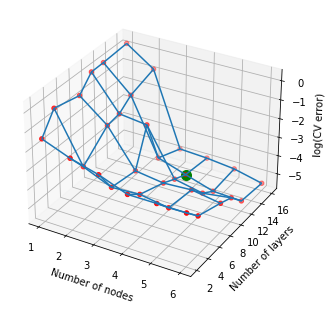

In [14]:
from mpl_toolkits.mplot3d import Axes3D

Z=[]
for i in range(6):
    Z.append(np.array(lst[6*i:6*(i+1)]))
Z = np.log(np.array(Z))


x = np.array(layers)
y = np.array(nodes)
X, Y = np.meshgrid(x, y)


fig=plt.figure()
ax=Axes3D(fig)
ax.scatter(X[-2,-3], Y[-2,-3], Z[-2,-3], c="g", s=100)  # Mark a optimal point
ax.scatter(X,Y,Z, c="r")
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)

ax.set_xlabel("Number of nodes")
ax.set_ylabel("Number of layers")
ax.set_zlabel("log(CV error)")


Despite efforts, there is still randomness involved, so can't take the ideal value of six layers and 16 nodes too seriously, especially because there is such a small difference between best values. Further experimentation showed 5 layers and 12 nodes struck the right balance of accuracy and simplicity, so that is what we will use going foward.

Test updated model

Epoch 1/40
219/219 - 1s - loss: 0.4372 - val_loss: 0.0364 - 945ms/epoch - 4ms/step
Epoch 2/40
219/219 - 0s - loss: 0.0311 - val_loss: 0.0241 - 362ms/epoch - 2ms/step
Epoch 3/40
219/219 - 0s - loss: 0.0239 - val_loss: 0.0191 - 362ms/epoch - 2ms/step
Epoch 4/40
219/219 - 0s - loss: 0.0202 - val_loss: 0.0195 - 369ms/epoch - 2ms/step
Epoch 5/40
219/219 - 0s - loss: 0.0159 - val_loss: 0.0125 - 363ms/epoch - 2ms/step
Epoch 6/40
219/219 - 0s - loss: 0.0125 - val_loss: 0.0094 - 380ms/epoch - 2ms/step
Epoch 7/40
219/219 - 0s - loss: 0.0102 - val_loss: 0.0074 - 378ms/epoch - 2ms/step
Epoch 8/40
219/219 - 0s - loss: 0.0076 - val_loss: 0.0096 - 351ms/epoch - 2ms/step
Epoch 9/40
219/219 - 0s - loss: 0.0065 - val_loss: 0.0082 - 372ms/epoch - 2ms/step
Epoch 10/40
219/219 - 0s - loss: 0.0047 - val_loss: 0.0032 - 368ms/epoch - 2ms/step
Epoch 11/40
219/219 - 0s - loss: 0.0049 - val_loss: 0.0059 - 356ms/epoch - 2ms/step
Epoch 12/40
219/219 - 0s - loss: 0.0041 - val_loss: 0.0028 - 365ms/epoch - 2ms/step
E

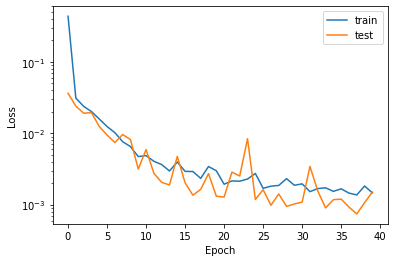

Training Set R-Square= 0.9987962813598774


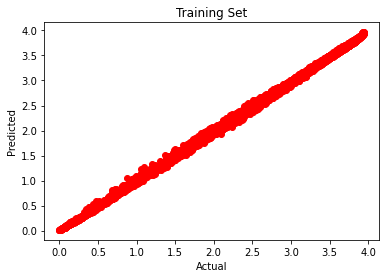

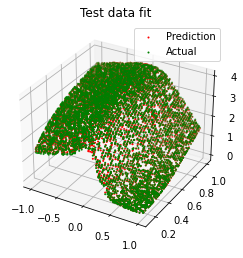

In [15]:
def build_model(num_nodes, num_layers):
    model = Sequential()
    model.add(Dense(num_nodes, activation="relu", input_dim=2))
    # Add (num_layers - 1) more layers to NN
    for _ in range(len(range(num_layers))-1):
        model.add(Dense(num_nodes, activation="relu"))
    # Add activation layer
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer=SGD(momentum=0.01, nesterov=True))
    return model

# Build model
model = build_model(16, 6)

# Fit the model
history = model.fit(X_train.T, Y_train.T, validation_data=(X_val.T, Y_val.T), epochs=40, verbose=2)

# Calculate predictions on test and validation set
PredTestSet = model.predict(X_test.T)
PredValSet = model.predict(X_val.T)

# Plot loss
plt.semilogy(history.history['loss'], label='train')
plt.semilogy(history.history['val_loss'], label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot actual vs prediction for training set
plt.plot(A_test,PredTestSet,'ro')
plt.title('Training Set')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Compute R-Square value for training set
TestR2Value = r2_score(A_test,PredTestSet)
print("Training Set R-Square=", TestR2Value)

# See how predictions on test set fit data
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter3D(T_test, Q_test, PredTestSet.T[0], c="red", s=1, label="Prediction")
ax.scatter3D(T_test, Q_test, A_test, c="green", s=1, label="Actual")
ax.set_title("Test data fit")
ax.legend()

Maybe slightly overfitted, but still makes better predictions

#### Grid search for learning rate and momentum

In [16]:
learning_rate = [0.001, 0.01, 0.03, 0.06, 0.08]
momentum = [0.0, 0.1, 0.2, 0.4, 0.6, 0.8]

def build_model(learning_rate, momentum):
    model = Sequential()
    # Use 32 node 4 layer model from before
    model.add(Dense(32, activation="relu", input_dim=2))
    for _ in range(3):
        model.add(Dense(32, activation="relu"))
    model.add(Dense(1, activation="linear"))
    # Variable learning rate and momentum
    model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True))
    return model

lst = []    # Store CV error
i=0         # Keep track of index
# Loop over layer and node sixe
for rate in learning_rate:
    for momenta in momentum:
        # Take average over 3 runs, minimize randomness
        CV_sum = 0
        for _ in range(3):
            model = build_model(rate, momenta)
            history = model.fit(X_train.T, Y_train.T, validation_data=(X_val.T, Y_val.T),
                    epochs=10, verbose=0)
            CV = history.history['val_loss'][-1]    # CV error at last epoch
            CV_sum += CV
        CV = CV_sum / 3
        print(f"{i}: momentum {momenta}, learning rate {rate}, has cross validation error {CV}")
        lst.append(CV)                              # Save for later analysis
        i += 1

        

0: momentum 0.0, learning rate 0.001, has cross validation error 0.07712600628534953
1: momentum 0.1, learning rate 0.001, has cross validation error 0.04125206917524338
2: momentum 0.2, learning rate 0.001, has cross validation error 0.038440088431040444
3: momentum 0.4, learning rate 0.001, has cross validation error 0.03639094531536102
4: momentum 0.6, learning rate 0.001, has cross validation error 0.026017601912220318
5: momentum 0.8, learning rate 0.001, has cross validation error 0.014526630751788616
6: momentum 0.0, learning rate 0.01, has cross validation error 0.00591240629243354
7: momentum 0.1, learning rate 0.01, has cross validation error 0.005213858637337883
8: momentum 0.2, learning rate 0.01, has cross validation error 0.003005494208385547
9: momentum 0.4, learning rate 0.01, has cross validation error 0.0027531159576028585
10: momentum 0.6, learning rate 0.01, has cross validation error 0.0016755398052434127
11: momentum 0.8, learning rate 0.01, has cross validation e

In [17]:
sorted(enumerate(lst),key=lambda x: x[-1])  # Get sorted list of best model parameters, best parameters are lr=0.01, momentum=0.8

[(11, 0.0006719395169056952),
 (20, 0.0008453172049485147),
 (25, 0.0008581473181645075),
 (27, 0.0008706197841092944),
 (21, 0.0012477364701529343),
 (16, 0.0012618682424848278),
 (18, 0.001310911475835989),
 (29, 0.001325826703881224),
 (19, 0.0014489160384982824),
 (12, 0.0015445206857596834),
 (10, 0.0016755398052434127),
 (17, 0.0016817466045419376),
 (14, 0.0016946815109501283),
 (28, 0.0017359943012706935),
 (23, 0.0017761592365180452),
 (13, 0.002641160972416401),
 (9, 0.0027531159576028585),
 (15, 0.002892546025880923),
 (8, 0.003005494208385547),
 (26, 0.0037636576841274896),
 (24, 0.004679691124086578),
 (7, 0.005213858637337883),
 (6, 0.00591240629243354),
 (22, 0.00615348635862271),
 (5, 0.014526630751788616),
 (4, 0.026017601912220318),
 (3, 0.03639094531536102),
 (2, 0.038440088431040444),
 (1, 0.04125206917524338),
 (0, 0.07712600628534953)]

Optimal parameters are learning_rate = 0.01, and momentum = 0.8

#### Test final model parameters

In [18]:
# Training data
X_train = np.array([Q_train, T_train])
Y_train = np.array([A_train])

# Validation data
X_val = np.array([Q_val, T_val])
Y_val = np.array([A_val])

# Testing data
X_test = np.array([Q_test, T_test])
Y_test = np.array([A_test])

# Create model
model = Sequential()
model.add(Dense(16, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="linear"))

# Compile model
model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum=0.8, nesterov=True))

# Fit the model
history = model.fit(X_train.T, Y_train.T, validation_data=(X_val.T, Y_val.T), epochs=25, verbose=2)

# Calculate predictions on test and validation set
PredTestSet = model.predict(X_test.T)
PredValSet = model.predict(X_val.T)

Epoch 1/25


c:\Users\jmonc\anaconda3\envs\ISC505\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1094/1094 - 2s - loss: 0.0816 - val_loss: 0.0011 - 2s/epoch - 2ms/step
Epoch 2/25
1094/1094 - 2s - loss: 0.0014 - val_loss: 9.6111e-04 - 2s/epoch - 2ms/step
Epoch 3/25
1094/1094 - 2s - loss: 0.0011 - val_loss: 8.6727e-04 - 2s/epoch - 2ms/step
Epoch 4/25
1094/1094 - 2s - loss: 9.9417e-04 - val_loss: 7.8776e-04 - 2s/epoch - 2ms/step
Epoch 5/25
1094/1094 - 2s - loss: 8.7392e-04 - val_loss: 8.4923e-04 - 2s/epoch - 2ms/step
Epoch 6/25
1094/1094 - 2s - loss: 8.7313e-04 - val_loss: 6.6424e-04 - 2s/epoch - 1ms/step
Epoch 7/25
1094/1094 - 2s - loss: 8.5384e-04 - val_loss: 8.5085e-04 - 2s/epoch - 2ms/step
Epoch 8/25
1094/1094 - 2s - loss: 7.6244e-04 - val_loss: 5.9334e-04 - 2s/epoch - 2ms/step
Epoch 9/25
1094/1094 - 2s - loss: 7.7994e-04 - val_loss: 6.1075e-04 - 2s/epoch - 2ms/step
Epoch 10/25
1094/1094 - 2s - loss: 7.2906e-04 - val_loss: 5.7394e-04 - 2s/epoch - 2ms/step
Epoch 11/25
1094/1094 - 1s - loss: 7.3376e-04 - val_loss: 8.2549e-04 - 1s/epoch - 1ms/step
Epoch 12/25
1094/1094 - 1s - loss: 

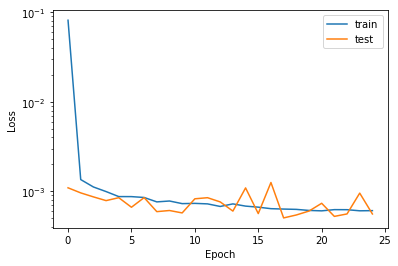

Training Set R-Square= 0.9995718709527097


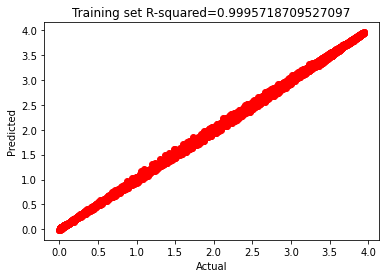

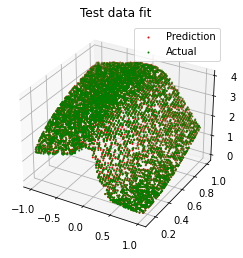

In [19]:
# Plot loss
plt.semilogy(history.history['loss'], label='train')
plt.semilogy(history.history['val_loss'], label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Compute R-Square value for training set
TestR2Value = r2_score(A_test,PredTestSet)
print("Training Set R-Square=", TestR2Value)

# Plot actual vs prediction for training set
plt.plot(A_test,PredTestSet,'ro')
plt.title(f"Training set R-squared={TestR2Value}")
plt.xlabel('Actual')
plt.ylabel('Predicted')

# See how predictions on test set fit data
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter3D(T_test, Q_test, PredTestSet.T[0], c="red", s=1, label="Prediction")
ax.scatter3D(T_test, Q_test, A_test, c="green", s=1, label="Actual")
ax.set_title("Test data fit")
ax.legend()

Definitely better than original model, with $R^2=0.9996$. Should note that with its added complexity, it may not be as good of a model than the original two layer model, since a simple regression problem like this perhaps need not be this complex

# Regenerate original data with **NN**

Use whole dataset

In [20]:
Q, T = np.meshgrid(q, t)
Q, T = Q.T / 8, T.T / 1e-2
A = amplitudes / 1e-19
X = np.array([Q.flatten(), T.flatten()])

Use generated model to predict output

In [21]:
%timeit
Y = model.predict(X.T)

1775/1775 [==============================] - 2s 1ms/step


Plot result for comparison

C:\Users\jmonc\AppData\Local\Temp\ipykernel_4068\1495596176.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


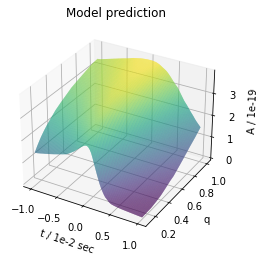

In [27]:
fig = plt.figure()
ax = plt.axes(projection='3d')

model_prediction = Y.T[0].reshape(701, 81)
ax.plot_surface(T, Q, model_prediction, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

ax.set_title('Model prediction')
ax.set_xlabel('t / 1e-2 sec')
ax.set_ylabel('q')
ax.set_zlabel('A / 1e-19')

fig.show()

Looks much alike the original figure.